Loading and preprocessing data...
Data loaded successfully. Performing feature engineering...
Data preprocessing completed successfully.

Sample of processed data:
  Gender  Age      Neighbourhood  Scholarship  Hipertension  Diabetes  \
0      F   62    JARDIM DA PENHA            0             1         0   
1      M   56    JARDIM DA PENHA            0             0         0   
2      F   62      MATA DA PRAIA            0             0         0   
3      F    8  PONTAL DE CAMBURI            0             0         0   
4      F   56    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handcap  SMS_received  DaysUntilAppointment  ScheduledHour  \
0           0        0             0                    -1             18   
1           0        0             0                    -1             16   
2           0        0             0                    -1             16   
3           0        0             0                    -1             17   
4           

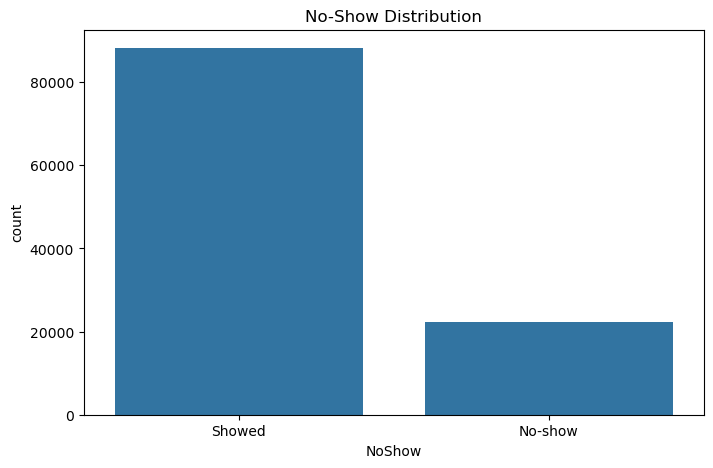

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load and preprocess data
def load_and_preprocess(filepath):
    try:
        df = pd.read_csv(filepath)
        
        # Convert dates and calculate days between scheduling and appointment
        df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
        df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
        df['DaysUntilAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
        
        # Extract temporal features
        df['ScheduledHour'] = df['ScheduledDay'].dt.hour
        df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek
        df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
        
        # Target variable
        df['NoShow'] = df['No-show'].map({'Yes': 1, 'No': 0})
        
        # Drop unnecessary columns
        df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'No-show'], 
                axis=1, inplace=True)
        
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Feature engineering
def feature_engineering(df):
    try:
        # Create age groups
        bins = [0, 12, 19, 30, 50, 65, 120]
        labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior', 'Elderly']
        df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
        
        # Create time of day categories
        df['TimeOfDay'] = pd.cut(df['ScheduledHour'], 
                                bins=[0, 8, 12, 16, 24], 
                                labels=['Early', 'Morning', 'Afternoon', 'Evening'],
                                include_lowest=True)
        
        return df
    except Exception as e:
        print(f"Error in feature engineering: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # Correct file path for Windows
    filepath = r"C:\Users\TEJASWINI\Desktop\healthcare.csv"
    
    # Check if file exists
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        print("Please verify the file path and try again.")
    else:
        # Load and preprocess data
        print("Loading and preprocessing data...")
        df = load_and_preprocess(filepath)
        
        if df is not None:
            print("Data loaded successfully. Performing feature engineering...")
            df = feature_engineering(df)
            
            if df is not None:
                print("Data preprocessing completed successfully.")
                print("\nSample of processed data:")
                print(df.head())
                
                # Basic data analysis
                print("\nBasic Statistics:")
                print(df.describe())
                
                # No-show rate
                no_show_rate = df['NoShow'].mean()
                print(f"\nOverall no-show rate: {no_show_rate:.2%}")
                
                # Plot no-show distribution
                plt.figure(figsize=(8, 5))
                sns.countplot(x='NoShow', data=df)
                plt.title('No-Show Distribution')
                plt.xticks([0, 1], ['Showed', 'No-show'])
                plt.show()
            else:
                print("Error during feature engineering.")
        else:
            print("Error loading data file.")

Loading data...
Engineering features...

 Training Random Forest model...

 Model Performance:
Accuracy: 0.80
ROC-AUC Score: 0.74

 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     17669
           1       0.50      0.16      0.24      4437

    accuracy                           0.80     22106
   macro avg       0.66      0.56      0.56     22106
weighted avg       0.76      0.80      0.75     22106



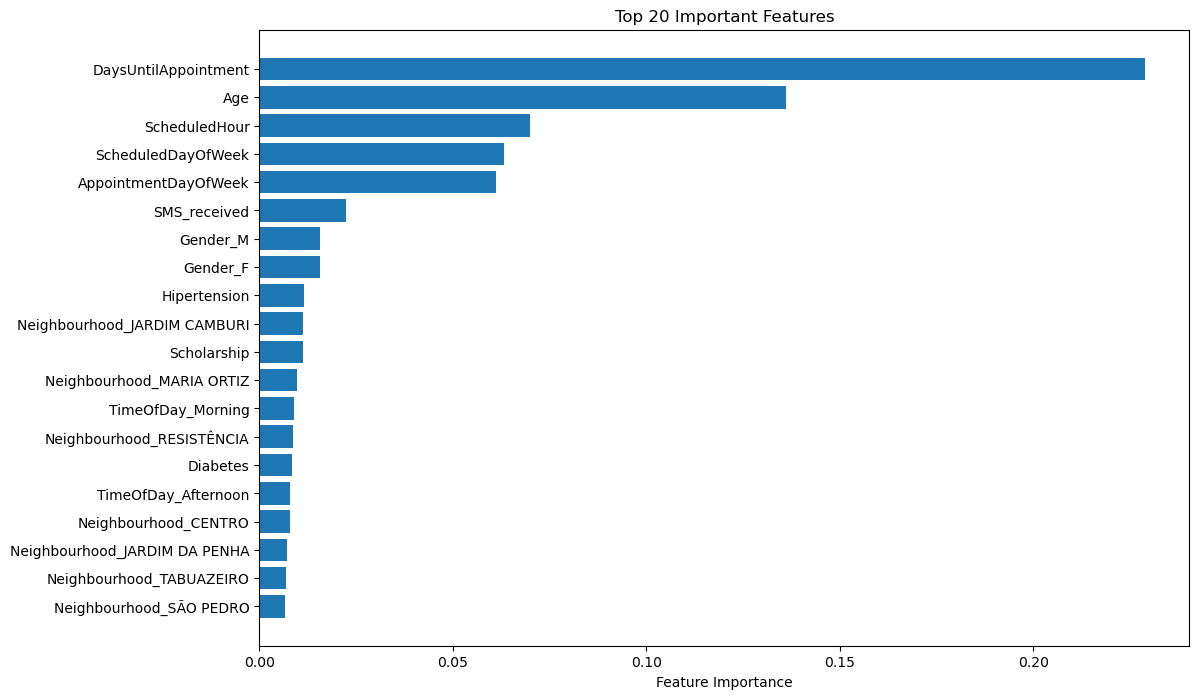


 Generating recommendations...

 No-show probability: 7.0%

 Low Risk: Low no-show probability (<40%)
Recommended actions:
  - Standard SMS reminder 24h before
  - General health information

Hypertension Care: 
Recommended actions:
  - Remind to bring BP logs
  - Morning appointments preferred
  - Provide low-sodium diet tips


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ----------------------------
# 1. Data Loading & Preprocessing
# ----------------------------
def load_and_preprocess(filepath):
    try:
        df = pd.read_csv(filepath)
        
        # Convert dates and calculate days until appointment
        df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
        df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
        df['DaysUntilAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
        
        # Extract temporal features
        df['ScheduledHour'] = df['ScheduledDay'].dt.hour
        df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek  # Monday=0, Sunday=6
        df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
        
        # Target variable (NoShow: 1 = Missed, 0 = Attended)
        df['NoShow'] = df['No-show'].map({'Yes': 1, 'No': 0})
        
        # Drop unnecessary columns
        df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'No-show'], 
                axis=1, inplace=True)
        
        return df
    
    except Exception as e:
        print(f" Error loading data: {str(e)}")
        return None

# ----------------------------
# 2. Feature Engineering
# ----------------------------
def feature_engineering(df):
    try:
        # Age groups (better than raw age)
        bins = [0, 12, 19, 30, 50, 65, 120]
        labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior', 'Elderly']
        df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
        
        # Time of day categories
        df['TimeOfDay'] = pd.cut(df['ScheduledHour'], 
                                bins=[0, 8, 12, 16, 24], 
                                labels=['Early', 'Morning', 'Afternoon', 'Evening'],
                                include_lowest=True)
        
        return df
    
    except Exception as e:
        print(f"Error in feature engineering: {str(e)}")
        return None

# ----------------------------
# 3. Model Training & Evaluation
# ----------------------------
def train_and_evaluate(df):
    # Define features
    categorical_features = ['Gender', 'Neighbourhood', 'AgeGroup', 'TimeOfDay']
    numerical_features = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 
                         'Alcoholism', 'Handcap', 'SMS_received', 
                         'DaysUntilAppointment', 'ScheduledHour',
                         'AppointmentDayOfWeek', 'ScheduledDayOfWeek']
    
    target = 'NoShow'
    
    # Preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))  # Handles missing values
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categories
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Random Forest Model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'  # Handles imbalanced data
        ))
    ])
    
    # Split data
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    print("\n Training Random Forest model...")
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    print("\n Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature Importance
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        ohe_features = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        all_features = numerical_features + list(ohe_features)
        
        importances = model.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        plt.title("Top 20 Important Features")
        plt.barh(range(20), importances[indices][:20], align='center')
        plt.yticks(range(20), [all_features[i] for i in indices[:20]])
        plt.gca().invert_yaxis()
        plt.xlabel("Feature Importance")
        plt.show()
    
    return model

# ----------------------------
# 4. Generate Recommendations
# ----------------------------
def generate_recommendations(model, patient_data):
    # Predict no-show probability
    proba = model.predict_proba(pd.DataFrame([patient_data]))[0][1]
    
    recommendations = []
    
    # Risk-based recommendations
    if proba > 0.7:
        recommendations.append({
            'type': 'High Risk',
            'message': 'High no-show probability (>70%)',
            'actions': [
                'Send SMS + Phone reminders',
                'Offer flexible rescheduling',
                'Provide transportation options'
            ]
        })
    elif proba > 0.4:
        recommendations.append({
            'type': ' Medium Risk',
            'message': 'Moderate no-show probability (40-70%)',
            'actions': [
                'Send SMS reminder 48h before',
                'Confirm appointment 24h before',
                'Send condition-specific health tips'
            ]
        })
    else:
        recommendations.append({
            'type': ' Low Risk',
            'message': 'Low no-show probability (<40%)',
            'actions': [
                'Standard SMS reminder 24h before',
                'General health information'
            ]
        })
    
    # Condition-specific recommendations
    if patient_data.get('Hipertension', 0) == 1:
        recommendations.append({
            'type': 'Hypertension Care',
            'actions': [
                'Remind to bring BP logs',
                'Morning appointments preferred',
                'Provide low-sodium diet tips'
            ]
        })
    
    if patient_data.get('Diabetes', 0) == 1:
        recommendations.append({
            'type': ' Diabetes Care',
            'actions': [
                'Fasting reminder if bloodwork needed',
                'Suggest bringing glucose monitor',
                'Mid-morning appointments ideal'
            ]
        })
    
    return {
        'no_show_probability': proba,
        'recommendations': recommendations
    }

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == "__main__":
    # Load data
    filepath = r"C:\Users\TEJASWINI\Desktop\healthcare.csv"
    
    if not os.path.exists(filepath):
        print(f" Error: File not found at {filepath}")
    else:
        print("Loading data...")
        df = load_and_preprocess(filepath)
        
        if df is not None:
            print("Engineering features...")
            df = feature_engineering(df)
            
            if df is not None:
                # Train model
                model = train_and_evaluate(df)
                
                # Example patient for demo
                example_patient = {
                    'Gender': 'F',
                    'Age': 45,
                    'Neighbourhood': 'JARDIM DA PENHA',
                    'Scholarship': 0,
                    'Hipertension': 1,
                    'Diabetes': 0,
                    'Alcoholism': 0,
                    'Handcap': 0,
                    'SMS_received': 1,
                    'DaysUntilAppointment': 5,
                    'ScheduledHour': 10,
                    'AppointmentDayOfWeek': 2,
                    'ScheduledDayOfWeek': 1,
                    'AgeGroup': 'Adult',
                    'TimeOfDay': 'Morning'
                }
                
                # Generate recommendations
                print("\n Generating recommendations...")
                recs = generate_recommendations(model, example_patient)
                print(f"\n No-show probability: {recs['no_show_probability']:.1%}")
                
                for rec in recs['recommendations']:
                    print(f"\n{rec['type']}: {rec.get('message', '')}")
                    print("Recommended actions:")
                    for action in rec.get('actions', []):
                        print(f"  - {action}")